In [2]:
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import random
from matplotlib import colors
import copy
import time
import scipy.optimize

%matplotlib inline

In [285]:
# assumes periodic BCs
def metropolis_potts(init, q, boltz):
    """Returns a grid evolved one step in the q-state Potts model using the Metropolis algorithm"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    # randomly choose new state
    new_state = random.randint(1,q)
    
    # select random spin from the input spin grid
    x = random.choice(range(X))
    y = random.choice(range(Y))
    
    # checking the energy cost
    energy_i = potts_energy_spin(grid, [y,x])
    energy_f = potts_energy_spin(grid, [y,x], new_state)
    
    d_energy = int(energy_f - energy_i)
    
    # applying the metropolis algorithm
    if d_energy <= 0:
        grid[y,x] = new_state
        
    elif random.uniform(0,1) < boltz[str(d_energy)]:
        grid[y,x] = new_state
        
    else:
        d_energy = 0
        

    return [grid, d_energy]

In [222]:
# assumes periodic boundary condition
def heatbath_potts(init, q, boltz):
    """Returns a grid evolved one step in the q-state Potts model using the heat-bath algorithm"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    # select random spin from the input spin grid
    x = random.choice(range(X))
    y = random.choice(range(Y))
    
    
    # compute the relevant energies for the heat-bath algorithm (only nearest neighbor interactions)
    # we only want to compute the energies that are non-zero
    check = []
    check.append(grid[(y+1) % Y, x])
    check.append(grid[(y-1) % Y, x])
    check.append(grid[y % Y, (x+1) % X])
    check.append(grid[y % Y, (x-1) % X])
    check = list(set(check))
    
    
    
    # initialize the probabilities to 1 because the zero energies have boltzmann factor equal to 1
    probs = np.ones(q)
    
    # replace the appropriate elements with the boltzman factors; note that order in probs is important!
    for c in check:
        e = potts_energy_spin(grid, [y,x], c)
        probs[c-1] = boltz[str(e)]
        
    probs = np.array(probs)/np.sum(probs)   
    
    new_state = np.random.choice(range(1, q+1), p = probs)
    
    grid[y,x] = new_state
    
    return grid

    

In [195]:
T = 1
boltz = {'-1' : np.exp(1/T), '-2' : np.exp(2/T), '-3' : np.exp(3/T), '-4' : np.exp(4/T)}

a = np.array([[1, 2, 1], [1, 2, 1], [1, 2, 3]])

heatbath_potts(a, 3, boltz)

(0, 2)
[1, 2, 3]
[0.57611688 0.21194156 0.21194156]


array([[1, 2, 2],
       [1, 2, 1],
       [1, 2, 3]])

In [230]:
met_boltz = {'1' : np.exp(-1/T), '2' : np.exp(-2/T), '3' : np.exp(-3/T), '4' : np.exp(-4/T)}

metropolis_potts(a, 3, met_boltz)[0]

(2, 2) 1
-3


array([[1, 2, 1],
       [1, 2, 1],
       [1, 2, 1]])

In [46]:
def potts_energy_spin(init, spin, q = None):
    """Compute the energy of a spin on a Potts lattice"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    x = spin[1]
    y = spin[0]
    
    # allows you to change the value of the spin in question
    if q is not None:
        grid[y,x] = q
    
    energy = 0
    
    if grid[y, (x + 1) % X] == grid[y,x]:
        energy += -1

    if grid[y, (x - 1) % X] == grid[y,x]:
        energy += -1

    if grid[(y + 1) % Y, x] == grid[y,x]:
        energy += -1

    if grid[(y - 1) % Y, x] == grid[y,x]:
        energy += -1
    
    return energy
    
    
    

In [292]:
def potts_energy(init):
    """Computes the energy of a Potts grid"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    energy = 0
    
    for i in range(Y):
        for j in range(X):
            spin_energy = potts_energy_spin(init, [i,j])
            energy += spin_energy
            
    return energy/2
    
    

In [260]:
def plot_potts(grid, title = '', cmap = plt.cm.coolwarm):
    """Plot a Potts grid using a color map"""
    
    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(grid, cmap=cmap)
    plt.colorbar()
    
    plt.title(title, fontsize=20)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

In [315]:
random.seed(1)
init = np.random.randint(1, 11, (20, 20))
test = copy.copy(init)

T = 0.5
boltz = {'-1' : np.exp(1/T), '-2' : np.exp(2/T), '-3' : np.exp(3/T), '-4' : np.exp(4/T)}

In [311]:
energy_list = []

start = time.time()
for i in range(400*700):
    output = heatbath_potts(test, 10, boltz)
    energy_list.append(potts_energy(output))
    test = output
    if ((i+1) % 20000) == 0: 
        tick = time.time()
        print(f'Sweep {(i+1)/400}; {tick-start} seconds')
    
energy_list = np.array(energy_list)/400

np.save('potts20_heatbath.npy', energy_list)

Sweep 50.0; 21.43562364578247 seconds
Sweep 100.0; 43.12073588371277 seconds
Sweep 150.0; 64.63274383544922 seconds
Sweep 200.0; 86.3376955986023 seconds
Sweep 250.0; 108.86699938774109 seconds
Sweep 300.0; 130.2624475955963 seconds
Sweep 350.0; 151.79826402664185 seconds
Sweep 400.0; 173.8032956123352 seconds
Sweep 450.0; 195.3445680141449 seconds
Sweep 500.0; 216.99297666549683 seconds
Sweep 550.0; 238.74306392669678 seconds
Sweep 600.0; 260.4544644355774 seconds
Sweep 650.0; 281.83701634407043 seconds
Sweep 700.0; 303.24486470222473 seconds


In [316]:
met_boltz = {'1' : np.exp(-1/T), '2' : np.exp(-2/T), '3' : np.exp(-3/T), '4' : np.exp(-4/T)}

In [317]:
energy_list_met = []

start = time.time()
for i in range(400*700):
    output = metropolis_potts(test, 10, met_boltz)[0]
    energy_list_met.append(potts_energy(output))
    test = output
    if ((i+1) % 20000) == 0: 
        tick = time.time()
        print(f'Sweep {(i+1)/400}; {tick-start} seconds')
        
energy_list_met = np.array(energy_list_met)/400

np.save('potts20_met.npy', energy_list_met)

Sweep 50.0; 20.141063928604126 seconds
Sweep 100.0; 40.81433629989624 seconds
Sweep 150.0; 61.22522497177124 seconds
Sweep 200.0; 81.60883355140686 seconds
Sweep 250.0; 101.85405802726746 seconds
Sweep 300.0; 122.25552272796631 seconds
Sweep 350.0; 142.6594672203064 seconds
Sweep 400.0; 162.85905981063843 seconds
Sweep 450.0; 183.1717405319214 seconds
Sweep 500.0; 203.57022881507874 seconds
Sweep 550.0; 223.9419333934784 seconds
Sweep 600.0; 244.26850175857544 seconds
Sweep 650.0; 264.7890064716339 seconds
Sweep 700.0; 285.0218312740326 seconds


In [313]:
x_values = np.array([i for i in range(1,400*700+1)])/400

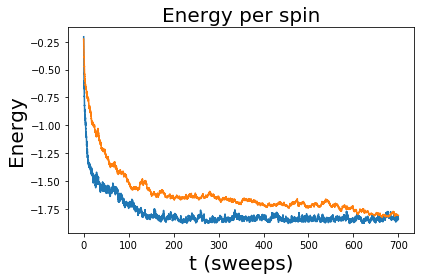

In [320]:
plt.plot(x_values,energy_list)
plt.plot(x_values,energy_list_met)
plt.title('Energy per spin', fontsize = 20)
plt.xlabel("t (sweeps)", fontsize=20)
plt.ylabel("Energy", fontsize=20)
plt.tight_layout()

In [339]:
random.seed(1)
init3 = np.random.randint(1, 4, (20, 20))
test3 = copy.copy(init3)

T = 0.5
boltz = {'-1' : np.exp(1/T), '-2' : np.exp(2/T), '-3' : np.exp(3/T), '-4' : np.exp(4/T)}

In [335]:
energy_list_q3 = []

start = time.time()
for i in range(400*700):
    output3 = heatbath_potts(test3, 3, boltz)
    energy_list_q3.append(potts_energy(output3))
    test3 = output3
    if ((i+1) % 20000) == 0: 
        tick = time.time()
        print(f'Sweep {(i+1)/400}; {tick-start} seconds')
    
energy_list_q3 = np.array(energy_list_q3)/400

np.save('potts20_heatbath_q3.npy', energy_list_q3)

Sweep 50.0; 21.67469596862793 seconds
Sweep 100.0; 42.98979139328003 seconds
Sweep 150.0; 64.0340723991394 seconds
Sweep 200.0; 85.33528017997742 seconds
Sweep 250.0; 106.42420077323914 seconds
Sweep 300.0; 127.53544092178345 seconds
Sweep 350.0; 148.63775300979614 seconds
Sweep 400.0; 169.72816133499146 seconds
Sweep 450.0; 191.00754570960999 seconds
Sweep 500.0; 214.37508940696716 seconds
Sweep 550.0; 238.94245600700378 seconds
Sweep 600.0; 260.24366426467896 seconds
Sweep 650.0; 281.44716024398804 seconds
Sweep 700.0; 302.8059046268463 seconds


In [340]:
energy_list_metq3 = []

start = time.time()
for i in range(400*700):
    output3 = metropolis_potts(test3, 3, met_boltz)[0]
    energy_list_metq3.append(potts_energy(output3))
    test3 = output3
    if ((i+1) % 20000) == 0: 
        tick = time.time()
        print(f'Sweep {(i+1)/400}; {tick-start} seconds')
        
energy_list_metq3 = np.array(energy_list_metq3)/400

np.save('potts20_met_q3.npy', energy_list_metq3)

Sweep 50.0; 19.850408792495728 seconds
Sweep 100.0; 39.7290894985199 seconds
Sweep 150.0; 59.59090614318848 seconds
Sweep 200.0; 79.5876350402832 seconds
Sweep 250.0; 99.84228348731995 seconds
Sweep 300.0; 122.00801920890808 seconds
Sweep 350.0; 142.90945172309875 seconds
Sweep 400.0; 163.29603624343872 seconds
Sweep 450.0; 184.0690050125122 seconds
Sweep 500.0; 204.2209813594818 seconds
Sweep 550.0; 224.29161405563354 seconds
Sweep 600.0; 244.63008666038513 seconds
Sweep 650.0; 265.48737502098083 seconds
Sweep 700.0; 286.0921995639801 seconds


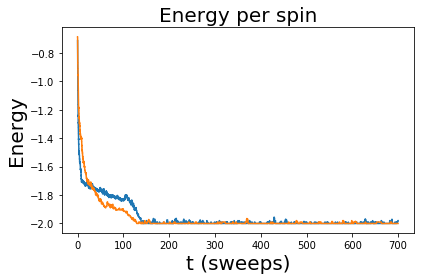

In [341]:
plt.plot(x_values, energy_list_q3)
plt.plot(x_values, energy_list_metq3)
plt.title('Energy per spin', fontsize = 20)
plt.xlabel("t (sweeps)", fontsize=20)
plt.ylabel("Energy", fontsize=20)
plt.tight_layout()